# Harmonic experiment

In [ ]:
%pip install --upgrade plotly numpy nbformat kaleido pandas

In [ ]:
import glob
import os
import pandas as pd
import numpy as np
import re
import plotly.express as px
import plotly.io as pio
from pathlib import Path
from IPython.display import display, Image

pio.kaleido.scope.mathjax = None

results_dir = Path("results").resolve()
print("Results directory:", results_dir)

Results directory: /mnt/lustre/ychatel/fuzzy-pytorch/experiments/harmonic/results


/tmp/ipykernel_956289/1457042936.py:11: DeprecationWarning:


Use of plotly.io.kaleido.scope.mathjax is deprecated and support will be removed after September 2025.
Please use plotly.io.defaults.mathjax instead.




In [2]:
def extract_hex(line):
    return float.fromhex(line.split("(")[1].split(")")[0])


def extract_values_default(file):
    with open(file, "r") as f:
        values = map(extract_hex, f.read().splitlines())
    return np.fromiter(values, dtype=np.float64)


def extract_cadna_line(line):
    # RESULT:  +5.18738175e+00 -- +5.18737698e+00 -- +5.18738509e+00
    return re.findall(r"\+\d+\.\d+e[+-]\d+", line)


def extract_values_cadna(file):
    with open(file, "r") as f:
        values = map(extract_cadna_line, f.read().splitlines())
        # flatten list of lists
        values = [item for sublist in values for item in sublist]
    return np.fromiter(values, dtype=np.float64)


def extract_values(file, tool):
    if "cadna" in tool:
        return extract_values_cadna(file)
    else:
        return extract_values_default(file)


def load_data(directory):
    files = glob.glob(os.path.join(directory, "*.txt"))
    df = pd.DataFrame(columns=["tool", "mode", "iterations"])
    for file in files:
        tool, mode, iterations = os.path.splitext(os.path.basename(file))[0].split("-")
        values = extract_values(file, tool)
        mean = np.mean(values)
        std = np.std(values)
        _df = pd.DataFrame(
            {
                "tool": [tool],
                "mode": [mode],
                "iterations": [int(iterations)],
                "mean": [mean],
                "std": [std],
            }
        )
        df = pd.concat([df, _df])
    return df

In [3]:
df = load_data(results_dir)
df.to_csv("harmonic-numerics.csv")
df

,tool,mode,iterations,mean,std
0,verificarlo,perf,613590,13.904262,0.000148
0,prism_ud,perf,37649,11.113365,0.000164
0,cadna,dbg,613590,13.891808,0.005804
0,prism_sr,perf,2477076,15.300161,0.000584
0,prism_ud,perf,284,6.227940,0.000005
...,...,...,...,...,...
0,verrou_cestac,dbg,14849,10.182983,0.000011
0,baseline_float,perf,100,5.187378,0.000000
0,baseline_double,dbg,486260,13.671716,0.000000
0,cadna,perf,3678,8.787480,0.000036


In [4]:
marker_map = {
    "baseline_double": "star",
    "baseline_float": "hexagram",
    "verrou_cestac": "x",
    "cadna": "x",
    "verrou_sr": "triangle-up",
    "prism_sr": "triangle-up",
    "prism_ud": "diamond",
    "sr": "triangle-up",
    "verificarlo": "triangle-up",
}

legend_map = {
    "prism_sr": "PRISM SR",
    "baseline_double": "IEEE binary64",
    "cadna": "CESTAC",
    "verificarlo": "MCA RR",
    "baseline_float": "IEEE binary32",
    "verrou_sr": "Verrou SR",
    "sr": "FM SR",
    "prism_ud": "PRISM UD",
    "verrou_cestac": "Verrou CESTAC",
}

legendgroup_map = {
    "prism_sr": "PRISM",
    "baseline_double": "IEEE",
    "cadna": "CADNA",
    "verificarlo": "MCA",
    "baseline_float": "IEEE",
    "verrou_sr": "VERROU",
    "sr": "SR",
    "prism_ud": "PRISM",
    "verrou_cestac": "VERROU",
}

colors_map = {
    "IEEE": "#a80ca8",
    "Verrou": "#ff7f0e",
    "PRISM": "#1f77b4",
    "CESTAC": "#1fb438",
    "FM SR": "#26b7e4",
    "MCA RR": "#f10202",
}

color_map = {
    "PRISM": colors_map["PRISM"],
    "VERROU": colors_map["Verrou"],
    "CADNA": colors_map["CESTAC"],
    "IEEE": colors_map["IEEE"],
    "SR": colors_map["FM SR"],
    "MCA": colors_map["MCA RR"],
}

## Combined Mean and Standard Deviation Plots

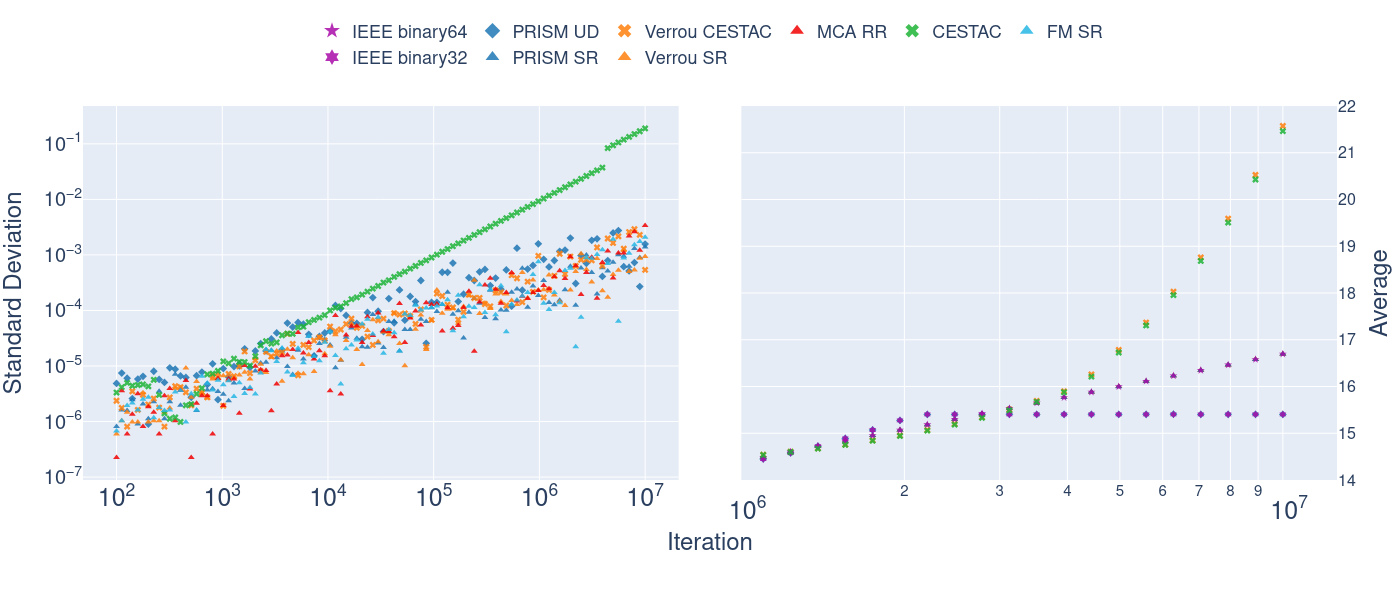

In [ ]:
from plotly.subplots import make_subplots

df = pd.read_csv("harmonic-numerics.csv")
df.sort_values(by=["iterations"], inplace=True)
df_perf = df[df["mode"] == "perf"]

# Create subplots with titles - Standard Deviation left, Average right
fig = make_subplots(
    rows=1, cols=2, x_title="Iteration", horizontal_spacing=0.05  # Decreased separation
)

# Create Std plot (left subplot)
fig_std = px.scatter(
    df_perf,
    x="iterations",
    y="std",
    color="tool",
    log_x=True,
    log_y=True,
)

# Apply all the styling from original std plot
for tool in df["tool"].unique():
    marker = marker_map.get(tool, "diamond")
    fig_std.update_traces(marker_symbol=marker, selector=dict(name=tool))

fig_std.for_each_trace(lambda t: t.update(legendgroup=(legendgroup_map[t.name])))

for tool in df["tool"].unique():
    new_name = legend_map.get(tool, tool)
    fig_std.for_each_trace(lambda t: t.update(name=new_name) if t.name == tool else ())

for trace in fig_std.data:
    trace.update(marker=dict(color=color_map[trace.legendgroup]))
    trace.update(line=dict(color=color_map[trace.legendgroup]))

fig_std.update_traces(marker=dict(size=6))
fig_std.update_traces(marker=dict(opacity=0.85))

# Create Mean plot (right subplot)
fig_mean = px.scatter(
    df_perf,
    x="iterations",
    y="mean",
    color="tool",
    log_x=True,
)

# Apply all the styling from original mean plot
for tool in df["tool"].unique():
    marker = marker_map.get(tool, "diamond")
    fig_mean.update_traces(marker_symbol=marker, selector=dict(name=tool))

fig_mean.for_each_trace(lambda t: t.update(legendgroup=(legendgroup_map[t.name])))

for tool in df["tool"].unique():
    new_name = legend_map.get(tool, tool)
    fig_mean.for_each_trace(lambda t: t.update(name=new_name) if t.name == tool else ())

for trace in fig_mean.data:
    trace.update(marker=dict(color=color_map[trace.legendgroup]))
    trace.update(line=dict(color=color_map[trace.legendgroup]))

fig_mean.update_traces(marker=dict(size=6))
fig_mean.update_traces(marker=dict(opacity=0.85))

# Add std traces to left subplot
for trace in fig_std.data:
    fig.add_trace(trace, row=1, col=1)

# Add mean traces to right subplot (without legend to avoid duplication)
for trace in fig_mean.data:
    trace.update(showlegend=False)
    fig.add_trace(trace, row=1, col=2)

# Update axes styling with increased tick font size
fig.update_xaxes(type="log", exponentformat="power")
fig.update_yaxes(
    type="log",
    exponentformat="power",
    title="Standard Deviation",
    row=1,
    col=1,
    tickfont=dict(size=16),
)
fig.update_yaxes(title="Average", side="right", row=1, col=2, tickfont=dict(size=16))

# Set y-axis to show only powers of 10 for left panel (Standard Deviation)
fig.update_yaxes(dtick=1, row=1, col=1)  # dtick=1 for log scale shows only powers of 10
fig.update_xaxes(dtick=1, row=1, col=1)  # dtick=1 for log scale shows only powers of 10

# Apply the same ranges as original plots - now for right subplot (Average)
fig.update_xaxes(range=[6, 7.1], row=1, col=2)
fig.update_yaxes(range=[14, 22], row=1, col=2)

# Reorder legend according to specified order: ieee, prism, verrou, mca, cestac, fm sr
legend_order = ["IEEE", "PRISM", "VERROU", "MCA", "CADNA", "SR"]
ordered_traces = []
for legendgroup in legend_order:
    for trace in fig.data:
        if (
            hasattr(trace, "legendgroup")
            and trace.legendgroup == legendgroup
            and trace.showlegend
        ):
            ordered_traces.append(trace)

# Clear existing traces and add in order
fig.data = []
for trace in ordered_traces:
    fig.add_trace(trace, row=1, col=1)

# Re-add mean traces (right subplot) without legend
for trace in fig_mean.data:
    trace.update(showlegend=False)
    fig.add_trace(trace, row=1, col=2)

# Update layout with centered legend and increased annotation font size for "Iteration"
fig.update_layout(
    font=dict(size=20),
    legend=dict(
        orientation="h",
        yanchor="top",
        y=1.25,
        xanchor="center",
        x=0.5,
        itemwidth=30,
        itemsizing="constant",
        font=dict(size=18),
    ),
    margin=dict(l=60, r=60, t=80, b=120),
    width=1400,
    height=600,
    xaxis=dict(
        title=dict(font=dict(size=24))
    ),  # Increased shared x-axis title font size
    annotations=[
        dict(
            text="Iteration",
            x=0.5,
            y=0,
            xref="paper",
            yref="paper",
            xanchor="center",
            yanchor="top",
            yshift=-50,
            showarrow=False,
            font=dict(size=24),  # Increased annotation font size from 16 to 28
        )
    ],
)

display(Image(fig.to_image(width=1400, height=600)))
fig.show()